In [1]:
# Libraries
import numpy as np
import pandas as pd
import warnings

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Stats
import scipy.stats as st
from scipy.stats import chi2_contingency # Chi-square test
from scipy.stats.contingency import association # Cramér's V
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import pingouin as pg # ANOVA test
from pingouin import welch_anova # Welch's ANOVA


# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.max_rows', None) # display all rows

[About the data](https://www.kaggle.com/datasets/ziya07/athlete-injury-and-performance-dataset)

It provides synthetic but realistic data for athletes, capturing their demographics, training regimes, schedules, fatigue levels, and injury risks.

**Features Overview**

1. Athlete Information
- Athlete_ID: Unique identifier for each athlete (e.g., A001, A002).
- Age: Athlete's age (18–25 years).
- Gender: Gender of the athlete (Male/Female).
- Height_cm: Height of the athlete in centimeters (160–200 cm).
- Weight_kg: Weight of the athlete in kilograms (55–100 kg).
- Position: Playing position in the team (Guard, Forward, Center).
2. Training Information
- Training_Intensity: Average intensity of training sessions on a scale of 1 (low) to 10 (high).
- Training_Hours_Per_Week: Total hours of training per week (5–20 hours).
- Recovery_Days_Per_Week: Number of days dedicated to recovery per week (1–3 days).
3. Schedule Information
- Match_Count_Per_Week: Number of matches scheduled per week (1–4 matches).
- Rest_Between_Events_Days: Average rest days between matches (1–3 days).
4. Derived Features
- Load_Balance_Score: A calculated score (0–100) indicating the balance between training load and recovery. A higher score reflects a better balance.
- ACL_Risk_Score: Predicted risk score (0–100) for ACL injuries. A higher score indicates a greater risk of injury.
5. Injury Information
- Injury_Indicator: Target column indicating whether the athlete sustained an ACL injury (1 = Yes, 0 = No).
6. Performance Metrics
- Fatigue_Score: Subjective fatigue level on a scale of 1 (low) to 10 (high).
- Performance_Score: Composite performance score (50–100) based on metrics like points scored and assists.
- Team_Contribution_Score: Athlete’s overall contribution to the team’s success on a scale of 50–100.

### Business Questions


- Are there more female or male with injury indicator = yes?

- Are there some relationships between the features?
- How does training information affect the performance metrics? 
- How does fatigue score and performance score interact with ACL risk?
- What demographic factors (e.g., age, gender, position) are most correlated with higher ACL_Risk_Score or Injury_Indicator?


In [2]:
data = pd.read_csv('collegiate_athlete_injury_dataset.csv')
data.head(5)

,Athlete_ID,Age,Gender,Height_cm,Weight_kg,Position,Training_Intensity,Training_Hours_Per_Week,Recovery_Days_Per_Week,Match_Count_Per_Week,Rest_Between_Events_Days,Fatigue_Score,Performance_Score,Team_Contribution_Score,Load_Balance_Score,ACL_Risk_Score,Injury_Indicator
0,A001,24,Female,195,99,Center,2,13,2,3,1,1,99,58,100,4,0
1,A002,21,Male,192,65,Forward,8,14,1,3,1,4,55,63,83,73,0
2,A003,22,Male,163,83,Guard,8,8,2,1,3,6,58,62,100,62,0
3,A004,24,Female,192,90,Guard,1,13,1,1,1,7,82,74,78,51,0
4,A005,20,Female,173,79,Center,3,9,1,2,1,2,90,51,83,49,0


### Column Standardization

In [3]:
data.columns = [column.lower().replace(" ", "_") for column in data.columns]

In [17]:
# Copy
df = data.copy()

### Data Cleaning

In [ ]:
df.isna().sum()

athlete_id                  0
age                         0
gender                      0
height_cm                   0
weight_kg                   0
position                    0
training_intensity          0
training_hours_per_week     0
recovery_days_per_week      0
match_count_per_week        0
rest_between_events_days    0
fatigue_score               0
performance_score           0
team_contribution_score     0
load_balance_score          0
acl_risk_score              0
injury_indicator            0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [18]:
df.set_index('athlete_id', inplace=True)

In [40]:
df.nunique()

athlete_id                  200
age                           7
gender                        2
height_cm                    39
weight_kg                    45
position                      3
training_intensity            9
training_hours_per_week      15
recovery_days_per_week        3
match_count_per_week          4
rest_between_events_days      3
fatigue_score                 9
performance_score            49
team_contribution_score      49
load_balance_score           31
acl_risk_score               73
injury_indicator              2
gender_enc                    2
position_enc                  3
dtype: int64

In [38]:
from sklearn.preprocessing import LabelEncoder

- position: 0 = Center, 1 = Forward, 2 = guard
- gender: 0 = Female, 1 = Male

In [39]:
encoder = LabelEncoder()
df['gender_enc'] = encoder.fit_transform(df["gender"])
df['position_enc'] = encoder.fit_transform(df["position"])
df.head()

,athlete_id,age,gender,height_cm,weight_kg,position,training_intensity,training_hours_per_week,recovery_days_per_week,match_count_per_week,rest_between_events_days,fatigue_score,performance_score,team_contribution_score,load_balance_score,acl_risk_score,injury_indicator,gender_enc,position_enc
0,A001,24,Female,195,99,Center,2,13,2,3,1,1,99,58,100,4,0,0,0
1,A002,21,Male,192,65,Forward,8,14,1,3,1,4,55,63,83,73,0,1,1
2,A003,22,Male,163,83,Guard,8,8,2,1,3,6,58,62,100,62,0,1,2
3,A004,24,Female,192,90,Guard,1,13,1,1,1,7,82,74,78,51,0,0,2
4,A005,20,Female,173,79,Center,3,9,1,2,1,2,90,51,83,49,0,0,0


In [ ]:
# Move the target to the right
target = df.pop('injury_indicator')
df['injury_indicator'] = target

### Numerical and Categorical 

In [47]:
cat = df.select_dtypes(exclude="number")
num = df.select_dtypes(include="number")

In [48]:
# being specific 
cat_from_num = num.loc[:, num.nunique() < 20] # how does .loc work Vs .iloc
cat2 = pd.concat([cat, cat_from_num], axis=1)

# removing numerical categorical data from num
num2 = num.drop(columns=cat_from_num.columns)

##### Adding categorical column for Fatigue Score

In [ ]:
# Conditions for the bins
conditions = [
    df['fatigue_score'] < 4, 
    (df['fatigue_score'] >= 4) & (df['fatigue_score'] <= 6),
    (df['fatigue_score'] >= 6) & (df['fatigue_score'] <= 8),
    df['fatigue_score'] > 8 
]

# Label each bin
labels = ['Very Low', 'Low', 'Medium', 'High']

# Create a new column with the bin labels
df['fatigue_level'] = pd.cut(
    df['fatigue_score'], 
    bins=[-float('inf'), 4, 6, 8, float('inf')],  # Define the range for bins
    labels=labels, 
    include_lowest=True
)

##### Adding categorical column for ACL risk

In [189]:
# Conditions for the bins
conditions = [
    df['acl_risk_score'] < 25, 
    (df['acl_risk_score'] >= 25) & (df['acl_risk_score'] <= 50),
    (df['acl_risk_score'] >= 51) & (df['acl_risk_score'] <= 75),
    df['acl_risk_score'] > 76 
]

# Label them
labels = ['Very Low', 'Low', 'Medium', 'High']

# New column with the bin labels
df['acl_risk'] = pd.cut(
    df['acl_risk_score'], 
    bins=[-float('inf'), 25, 50, 76, float('inf')],  # Define the range for bins
    labels=labels, 
    include_lowest=True
)

#### Adding categorical column to weight

In [196]:
# Conditions for the bins
conditions = [
    df['weight_kg'] < 64, 
    (df['weight_kg'] >= 64) & (df['weight_kg'] <= 77),
    (df['weight_kg'] >= 77) & (df['weight_kg'] <= 87),
    df['weight_kg'] > 87 
]

# Label them
labels = ['< 64', '64 - 77', '77 - 87', '87+']

# New column with the bin labels
df['weight_range'] = pd.cut(
    df['weight_kg'], 
    bins=[-float('inf'), 64, 77, 87, float('inf')],  # Define the range for bins
    labels=labels, 
    include_lowest=True
)

In [197]:
df.weight_range.value_counts() # 99 - 56

weight_range
64 - 77    63
87+        54
77 - 87    46
< 64       37
Name: count, dtype: int64

### Correlations

In [49]:
# Pearson Correlation value and release clause - Pearson & Spearman
pearson = df['rest_between_events_days'].corr(df['acl_risk_score'])
spearman = df['rest_between_events_days'].corr(df['acl_risk_score'], method='spearman')

print(f"Pearson Correlation: {pearson:.2f}")
print(f"Spearman Correlation: {spearman:.2f}")

Pearson Correlation: -0.05
Spearman Correlation: -0.07


In [151]:
num.corrwith(df['acl_risk_score']).sort_values(ascending=False)

acl_risk_score              1.000000
fatigue_score               0.649706
injury_indicator            0.525180
training_intensity          0.361971
training_hours_per_week     0.208818
team_contribution_score     0.123173
gender_enc                  0.086625
position_enc                0.080722
weight_kg                  -0.012700
age                        -0.021586
performance_score          -0.026019
match_count_per_week       -0.033123
height_cm                  -0.053553
rest_between_events_days   -0.053774
recovery_days_per_week     -0.303318
load_balance_score         -0.568265
dtype: float64

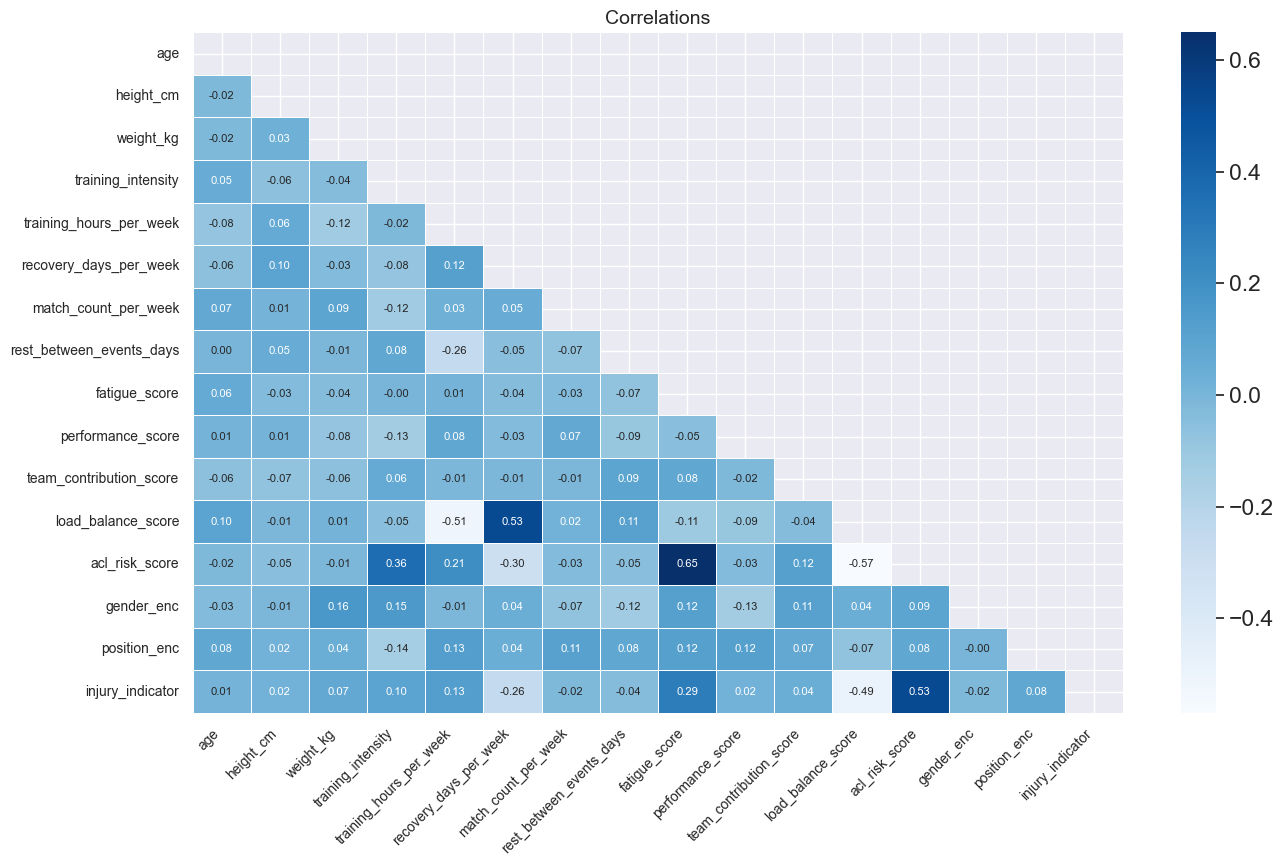

In [50]:
num_corr = round(num.corr(), 2)

# Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # hide top-half of the matrix
f, ax = plt.subplots(figsize=(14, 9))
sns.set(font_scale=1.5) # increase font size
ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 8}, linewidths=.5, cmap="Blues", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlations", fontsize=14) # add title
plt.xticks(rotation=45,  ha='right')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

### Chi-Square & Cramér's V

**Chi-square** tests the independence of two categorical variables by comparing observed frequencies to expected frequencies.

- The chi-square test is a statistical test used to **determine whether there is a significant association between two categorical variables**. 
- Interpretation: if p-value < 0.05, this suggests that there is a significant association between the categorical variables. P-value >= 0.05, indicates that there is not enough evidence to conclude a significant association between the variables.

**Cramér's V** measures the strength of the association between them. 

- Cramer's V is a measure of association used to **quantify the strength of the relationship between categorical variables**. 
- Interpretation: Cramer's V ranges from 0 to 1, where **0 indicates no association, and 1 represents a perfect association between the variables**. A higher value of Cramer's V indicates a stronger relationship between the categorical variables.

In [90]:
alpha = 0.05

In [215]:
crosstab_result = pd.crosstab(df['acl_risk'], df['weight_range'])

In [218]:
crosstab_result = pd.crosstab(df['acl_risk'], df['fatigue_score'])

In [219]:
crosstab_result

fatigue_score,1,2,3,4,5,6,7,8,9
acl_risk,,,,,,,,,
Very Low,8,10,1,4,3,0,0,0,0
Low,13,15,15,13,13,12,11,6,1
Medium,0,3,3,4,6,10,11,12,14
High,0,0,0,1,1,0,2,4,4


In [220]:
# Chi-square test for 'rest_between_events_days' and 'position'
chi2_stats, chi2_pvalue, _, _ = chi2_contingency(crosstab_result)
print(f"Chi-square p-value: {chi2_pvalue:.15f}")

if chi2_pvalue < alpha:
    print("There is an association between the categorical variables")
else:
    print("There is no association between the categorical variables")

Chi-square p-value: 0.000000000073782
There is an association between the categorical variables


In [214]:
# Checking the strngth of the association with "cramer" method
association(crosstab_result, method='cramer')

0.0752957899222459

In [228]:
crosstab_result2 = pd.crosstab(df['rest_between_events_days'], df['acl_risk'])
crosstab_result2

acl_risk,Very Low,Low,Medium,High
rest_between_events_days,,,,
1,6,35,24,4
2,9,35,19,4
3,11,29,20,4


In [222]:
df.fatigue_level.value_counts()

fatigue_level
Very Low    90
Medium      46
Low         45
High        19
Name: count, dtype: int64

In [221]:
df.columns

Index(['athlete_id', 'age', 'gender', 'height_cm', 'weight_kg', 'position',
       'training_intensity', 'training_hours_per_week',
       'recovery_days_per_week', 'match_count_per_week',
       'rest_between_events_days', 'fatigue_score', 'performance_score',
       'team_contribution_score', 'load_balance_score', 'acl_risk_score',
       'gender_enc', 'position_enc', 'injury_indicator', 'fatigue_level',
       'acl_risk', 'weight range', 'weight_range'],
      dtype='object')

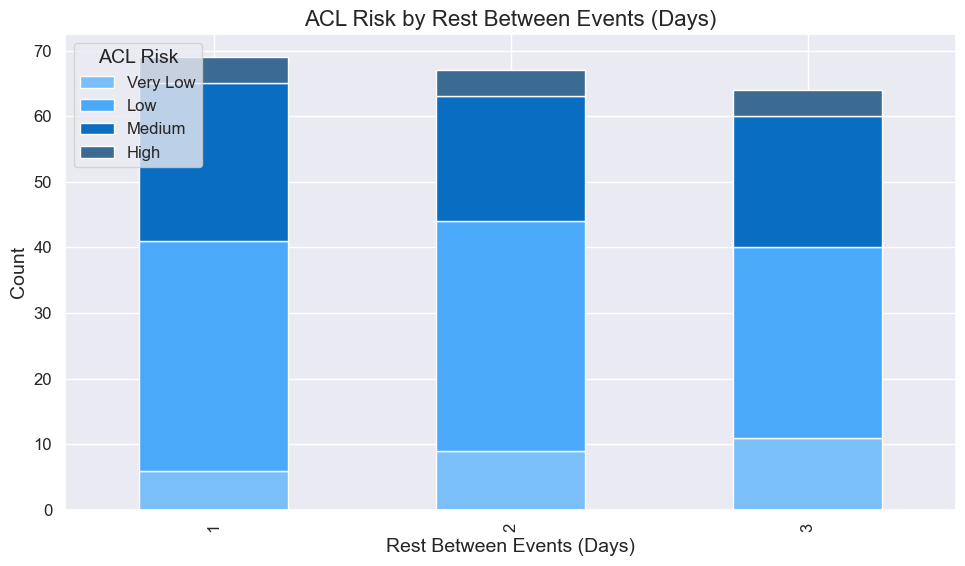

In [229]:
crosstab_result2.plot(kind='bar',
                    stacked=True,
                    color = ['#7bbff8', '#4aa9f9', '#096dc2', '#3b6b93'],
                    figsize=(10, 6))


plt.title('ACL Risk by Rest Between Events (Days)', fontsize=16)
plt.legend(title='ACL Risk', fontsize=12, title_fontsize=14, loc='upper left')  # Adjust title and label font sizes

# Adjust the font sizes for axis labels
plt.xlabel('Rest Between Events (Days)', fontsize=14)  # Customize x-axis label
plt.ylabel('Count', fontsize=14)                      # Customize y-axis label

# Customize tick parameters
plt.xticks(fontsize=12)  # Font size for x-axis ticks
plt.yticks(fontsize=12)  # Font size for y-axis ticks

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plot
plt.show()

### Freq tables

In [82]:
# Frequency Table
frequency_table = df.acl_risk.value_counts()

# Propotion 
proportion_table = df.acl_risk.value_counts(normalize=True) # If we do normalize=True, we get a proportion table

# create df
df_concat = pd.concat([frequency_table, proportion_table], axis=1)

# name columns
df_concat.columns = ['absolute_frequency', 'proportion']
round(df_concat, 2)

,absolute_frequency,proportion
acl_risk,,
Low,99,0.50
High,61,0.30
Very Low,26,0.13
Very High,14,0.07


### Groupby & Lambda

In [137]:
df1 = df.groupby('age').apply(lambda x: x.loc[x['acl_risk_score'].idxmax()])

df1

,athlete_id,age,gender,height_cm,weight_kg,position,training_intensity,training_hours_per_week,recovery_days_per_week,match_count_per_week,rest_between_events_days,fatigue_score,performance_score,team_contribution_score,load_balance_score,acl_risk_score,gender_enc,position_enc,injury_indicator,fatigue_level,acl_risk
age,,,,,,,,,,,,,,,,,,,,,
18,A145,18,Female,185,65,Forward,1,18,1,2,1,7,93,67,69,79,0,1,1,Medium,High
19,A095,19,Male,192,90,Center,3,17,1,1,1,5,64,69,66,81,1,0,1,Low,High
20,A129,20,Male,188,75,Forward,8,5,3,1,1,9,56,75,100,72,1,1,1,High,Medium
21,A191,21,Female,176,79,Guard,7,14,1,1,2,8,71,83,74,94,0,2,1,Medium,High
22,A120,22,Male,193,87,Guard,8,19,1,4,3,9,67,90,62,100,1,2,1,High,High
23,A085,23,Male,161,73,Guard,9,16,2,2,2,8,95,57,87,72,1,2,0,Medium,Medium
24,A040,24,Female,188,63,Guard,8,10,2,2,3,8,70,53,91,77,0,2,0,Medium,High


In [183]:
round(df.groupby(['gender'])['acl_risk_score'].mean().reset_index(),2)

,gender,acl_risk_score
0,Female,44.94
1,Male,48.23


In [181]:
round(df.groupby(['gender', 'injury_indicator'])[['weight_kg', 'height_cm', 'acl_risk_score']].mean().reset_index(),2)

,gender,injury_indicator,weight_kg,height_cm,acl_risk_score
0,Female,0,75.33,181.02,41.97
1,Female,1,79.62,180.00,81.75
2,Male,0,79.43,180.41,45.77
3,Male,1,81.67,184.00,83.83


In [161]:
round(df.groupby('gender')['weight_kg'].mean().reset_index(),2)

,gender,weight_kg
0,Female,75.65
1,Male,79.57


In [ ]:
# df2 = only players with ACL injury (1 = 'Yes')
df2 = df[df['injury_indicator'] == 1]

In [28]:
df2.groupby('gender')['injury_indicator'].count()

gender
Female    8
Male      6
Name: injury_indicator, dtype: int64

In [73]:
round(df.groupby('gender')['injury_indicator'].count(),2)

gender
Female    107
Male       93
Name: injury_indicator, dtype: int64

In [79]:
round(df.groupby(['gender', 'position'])['acl_risk_score'].agg(['mean', 'min', 'max', 'median']),2)

mean  min  max  median
gender position                         
Female Center    43.11    2   91    45.5
       Forward   42.69    7   84    37.0
       Guard     48.78   23   94    43.0
Male   Center    50.86   17   93    48.5
       Forward   43.45    9   76    44.0
       Guard     52.22   12  100    50.0

In [85]:
freq_table = df.recovery_days_per_week.value_counts()

In [87]:
freq_table.reset_index()

,recovery_days_per_week,count
0,2,69
1,1,67
2,3,64


### How does fatigue score and performance score interact with ACL risk?

In [138]:
df.head()

,athlete_id,age,gender,height_cm,weight_kg,position,training_intensity,training_hours_per_week,recovery_days_per_week,match_count_per_week,rest_between_events_days,fatigue_score,performance_score,team_contribution_score,load_balance_score,acl_risk_score,gender_enc,position_enc,injury_indicator,fatigue_level,acl_risk
0,A001,24,Female,195,99,Center,2,13,2,3,1,1,99,58,100,4,0,0,0,Very Low,Very Low
1,A002,21,Male,192,65,Forward,8,14,1,3,1,4,55,63,83,73,1,1,0,Very Low,Medium
2,A003,22,Male,163,83,Guard,8,8,2,1,3,6,58,62,100,62,1,2,0,Low,Medium
3,A004,24,Female,192,90,Guard,1,13,1,1,1,7,82,74,78,51,0,2,0,Medium,Medium
4,A005,20,Female,173,79,Center,3,9,1,2,1,2,90,51,83,49,0,0,0,Very Low,Low


/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/3415871521.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="acl_risk", y="performance_score", data=df, errorbar=None, palette="crest")


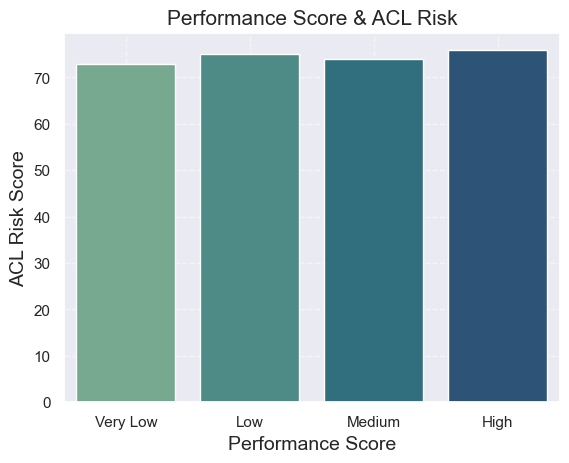

In [148]:

sns.barplot(x="acl_risk", y="performance_score", data=df, errorbar=None, palette="crest")
plt.title("Performance Score & ACL Risk", fontsize=15)
plt.xlabel("Performance Score", fontsize=14)
plt.ylabel("ACL Risk Score", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

### How does training information affect the performance metrics?


/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/1421913926.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="training_hours_per_week", y="performance_score", data=df, errorbar=None, palette="Paired")


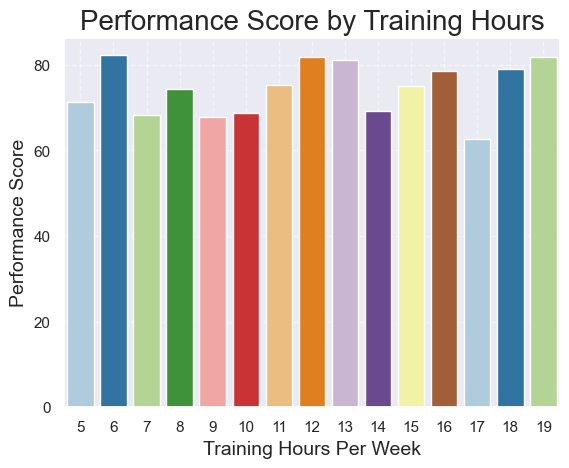

In [ ]:
# Hours vs. Performance Score
sns.barplot(x="training_hours_per_week", y="performance_score", data=df, errorbar=None, palette="Paired")
plt.title("Performance Score by Training Hours", fontsize=20)
plt.xlabel("Training Hours Per Week", fontsize=14)
plt.ylabel("Performance Score", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.5, linestyle='--')
plt.show()


/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/2509031940.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="training_hours_per_week", y="fatigue_score", data=df, errorbar=None, palette="Paired")


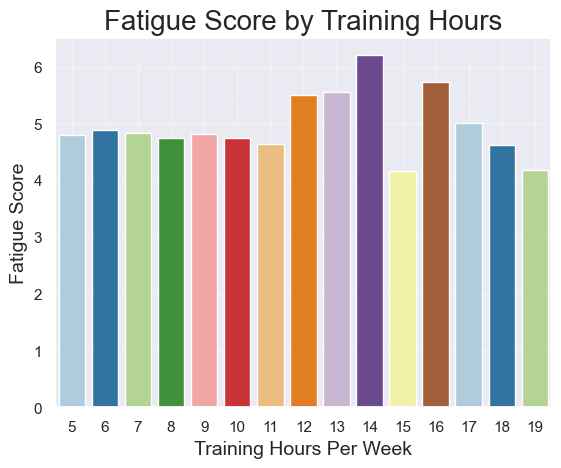

In [ ]:
# Hours vs. Fatigue Score
sns.barplot(x="training_hours_per_week", y="fatigue_score", data=df, errorbar=None, palette="Paired")
plt.title("Fatigue Score by Training Hours", fontsize=20)
plt.xlabel("Training Hours Per Week", fontsize=14)
plt.ylabel("Fatigue Score", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/3923486843.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="training_hours_per_week", y="team_contribution_score", data=df, errorbar=None, palette="Paired")


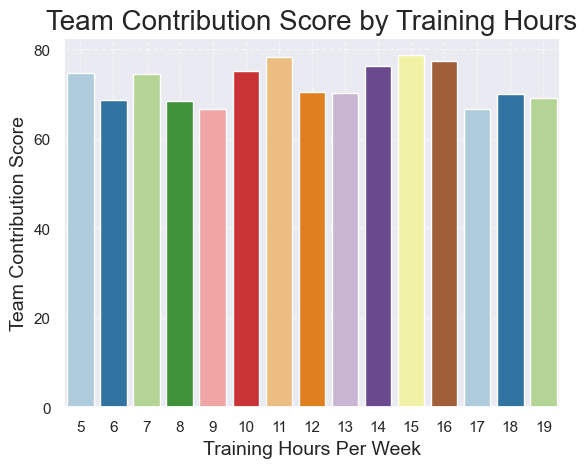

In [121]:
# Hours vs. Team Contribution Score
sns.barplot(x="training_hours_per_week", y="team_contribution_score", data=df, errorbar=None, palette="Paired")
plt.title("Team Contribution Score by Training Hours", fontsize=20)
plt.xlabel("Training Hours Per Week", fontsize=14)
plt.ylabel("Team Contribution Score", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

### How does recoovery days between event information affect the performance metrics?


/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/1770192422.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="rest_between_events_days", y="performance_score", data=df, errorbar=None, palette="Paired")


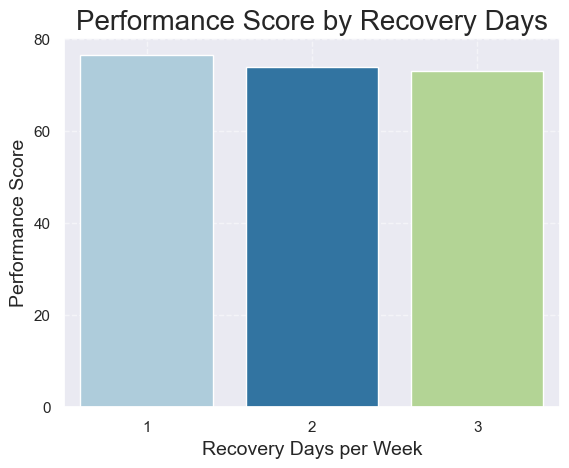

In [185]:
# Hours vs. Performance Score
sns.barplot(x="rest_between_events_days", y="performance_score", data=df, errorbar=None, palette="Paired")
plt.title("Performance Score by Recovery Days", fontsize=20)
plt.xlabel("Recovery Days per Week", fontsize=14)
plt.ylabel("Performance Score", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.5, linestyle='--')
plt.show()


/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/2509031940.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="training_hours_per_week", y="fatigue_score", data=df, errorbar=None, palette="Paired")


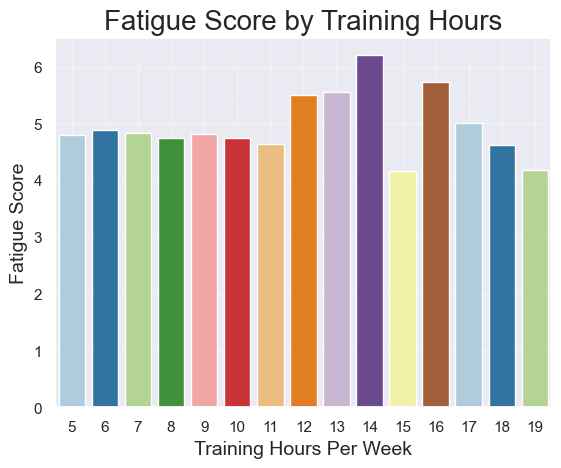

In [ ]:
# Hours vs. Fatigue Score
sns.barplot(x="training_hours_per_week", y="fatigue_score", data=df, errorbar=None, palette="Paired")
plt.title("Fatigue Score by Training Hours", fontsize=20)
plt.xlabel("Training Hours Per Week", fontsize=14)
plt.ylabel("Fatigue Score", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/3923486843.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="training_hours_per_week", y="team_contribution_score", data=df, errorbar=None, palette="Paired")


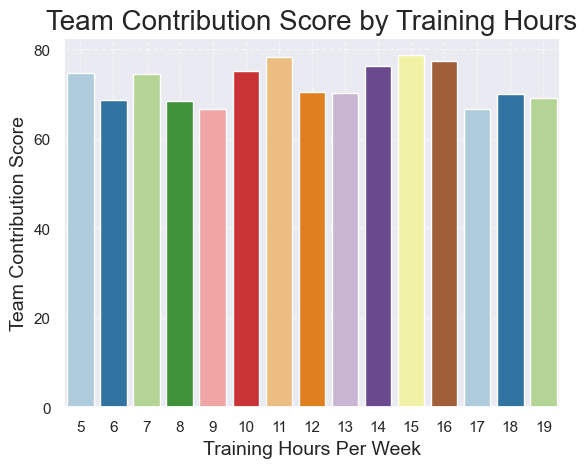

In [ ]:
# Hours vs. Team Contribution Score
sns.barplot(x="training_hours_per_week", y="team_contribution_score", data=df, errorbar=None, palette="Paired")
plt.title("Team Contribution Score by Training Hours", fontsize=20)
plt.xlabel("Training Hours Per Week", fontsize=14)
plt.ylabel("Team Contribution Score", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

## Other

/var/folders/d9/b5sfz3_12tv_8rtt32lkmw8h0000gn/T/ipykernel_5403/2998447983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='count', data=gender_counts, palette='Blues')


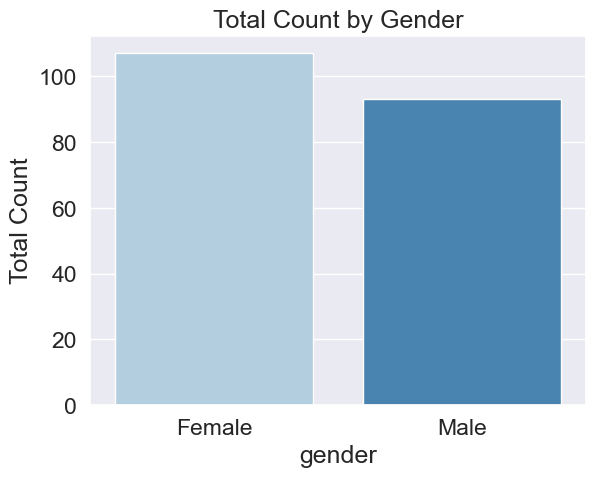

In [158]:
gender_counts = df['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']


sns.barplot(x='gender', y='count', data=gender_counts, palette='Blues')
plt.title('Total Count by Gender')
plt.ylabel('Total Count')
plt.show()

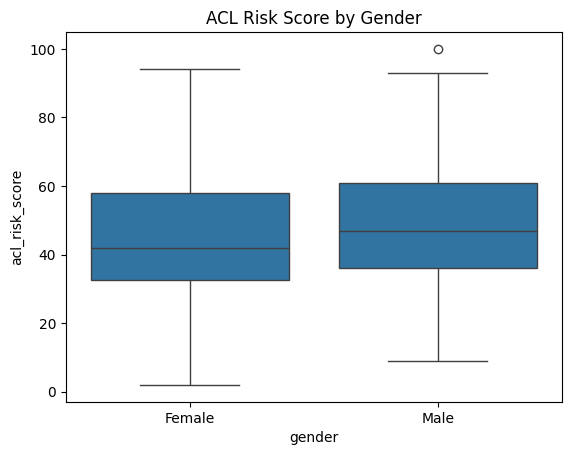

In [35]:
# What demographic factors (e.g., age, gender, position) are most correlated with higher ACL_Risk_Score or Injury_Indicator?
sns.boxplot(x='gender', y='acl_risk_score', data=df)
plt.title('ACL Risk Score by Gender')
plt.show()

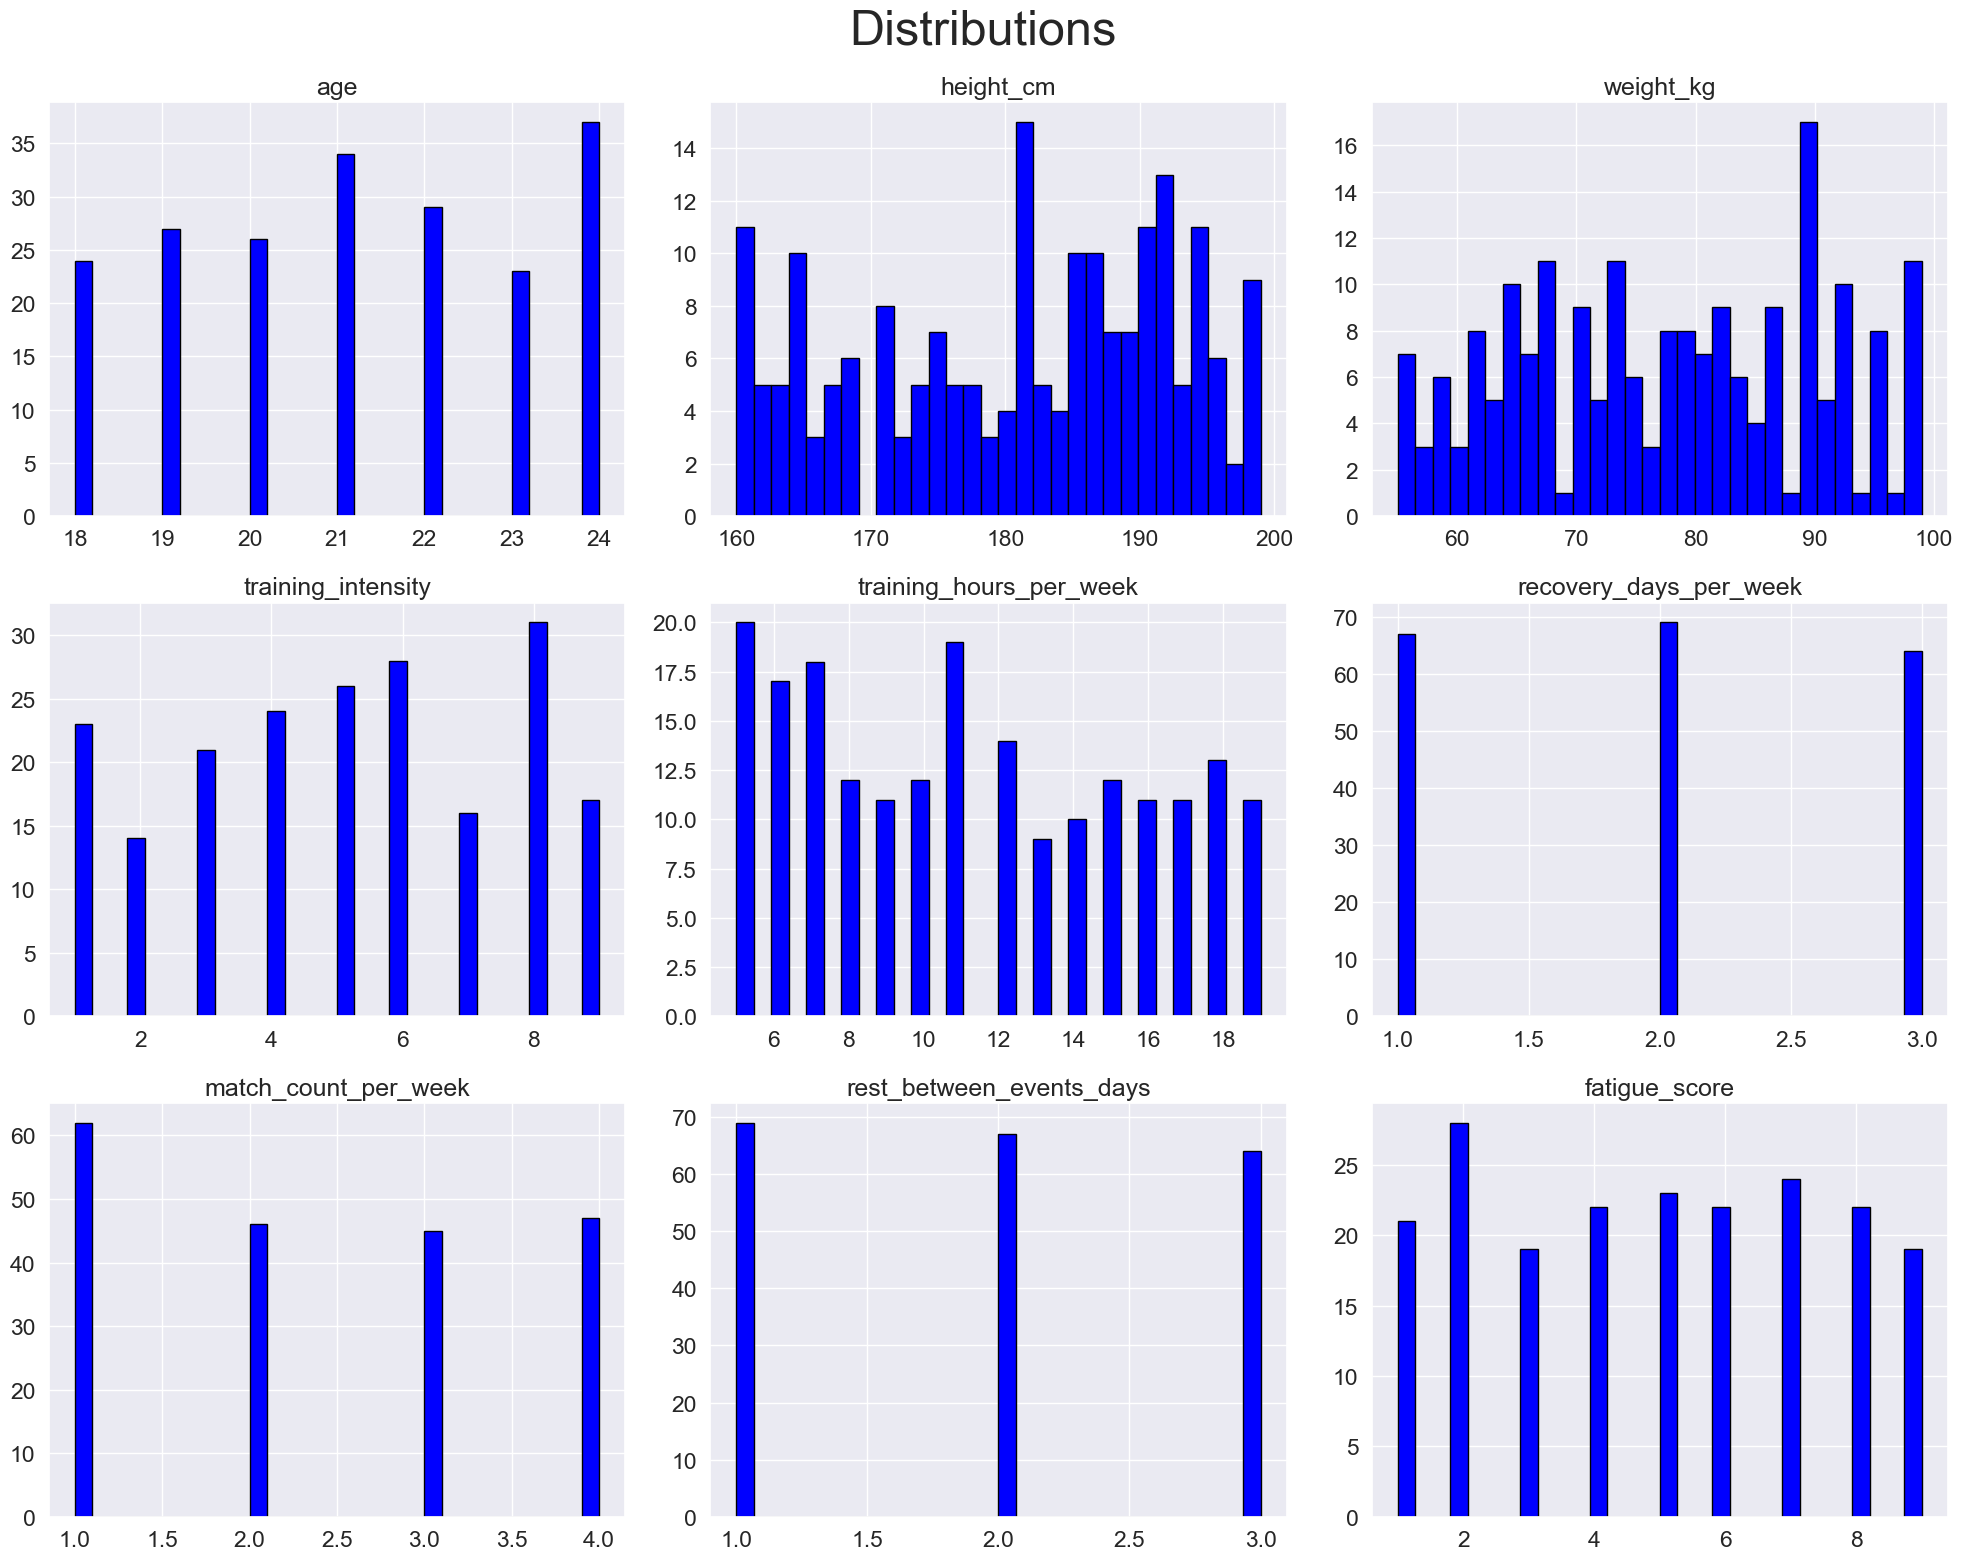

In [61]:
color = 'blue'

# grid size
nrows, ncols = 3, 3  # adjust for your number of features

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

# Plot each numerical feature
for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

# Add a central title
fig.suptitle("Distributions", fontsize=35)

plt.tight_layout()
plt.show()

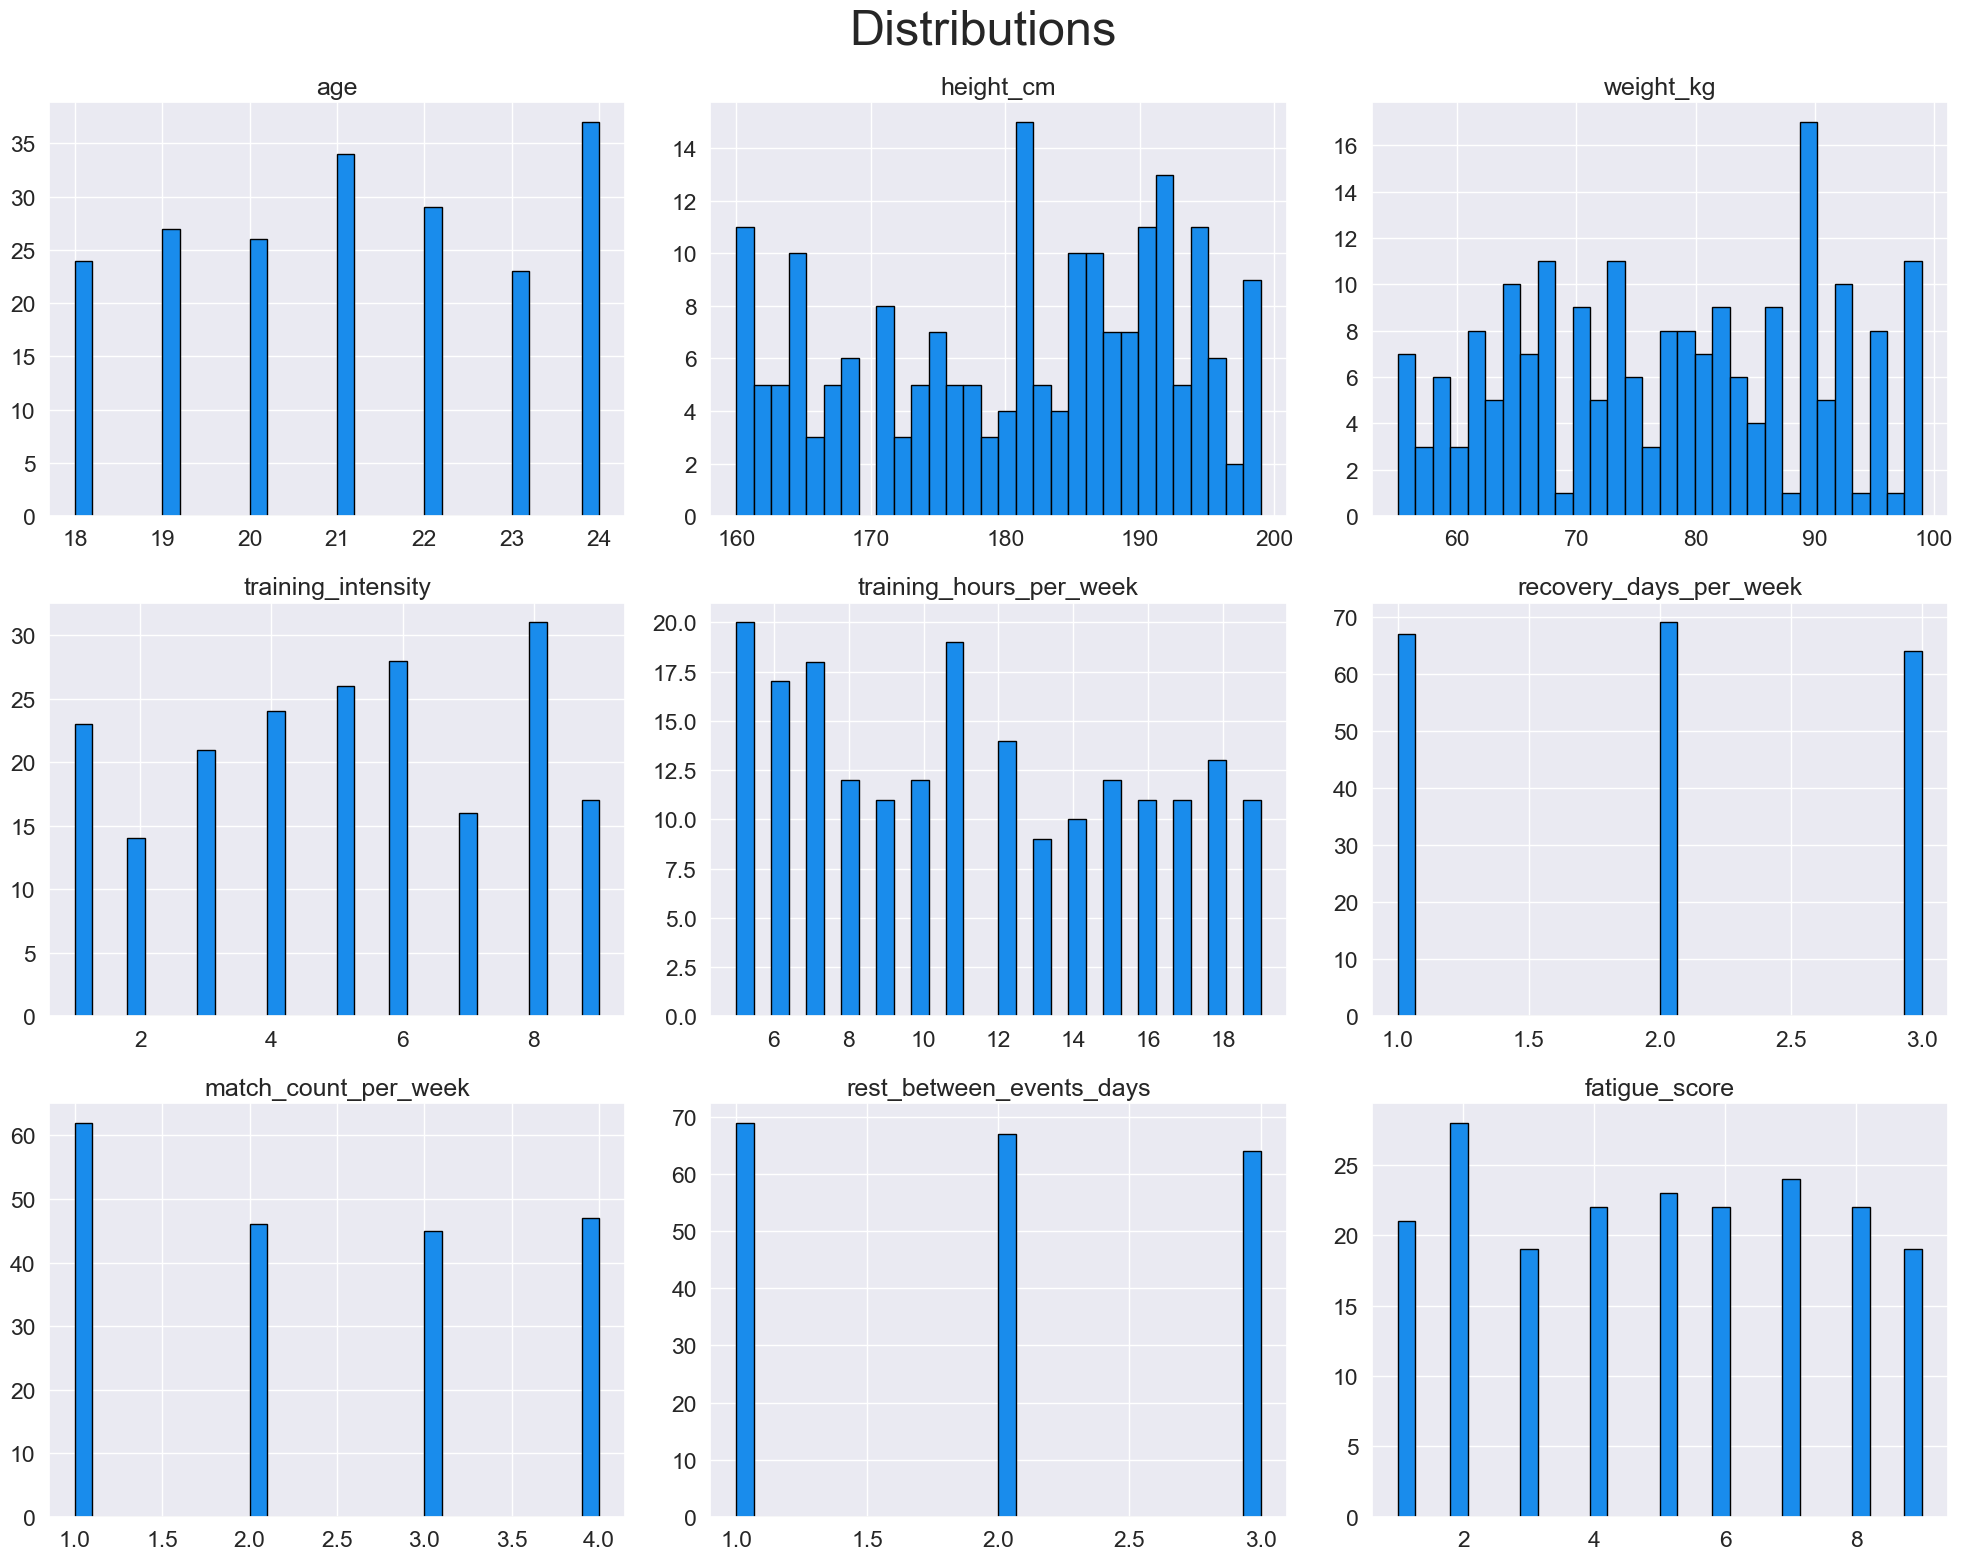

In [59]:
color = '#198cec'

# grid size
nrows, ncols = 3, 3  # adjust for your number of features

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

# Plot each numerical feature
for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

# Add a central title
fig.suptitle("Distributions", fontsize=35)

plt.tight_layout()
plt.show()

In [57]:
num.head()

,age,height_cm,weight_kg,training_intensity,training_hours_per_week,recovery_days_per_week,match_count_per_week,rest_between_events_days,fatigue_score,performance_score,team_contribution_score,load_balance_score,acl_risk_score,gender_enc,position_enc,injury_indicator
0,24,195,99,2,13,2,3,1,1,99,58,100,4,0,0,0
1,21,192,65,8,14,1,3,1,4,55,63,83,73,1,1,0
2,22,163,83,8,8,2,1,3,6,58,62,100,62,1,2,0
3,24,192,90,1,13,1,1,1,7,82,74,78,51,0,2,0
4,20,173,79,3,9,1,2,1,2,90,51,83,49,0,0,0


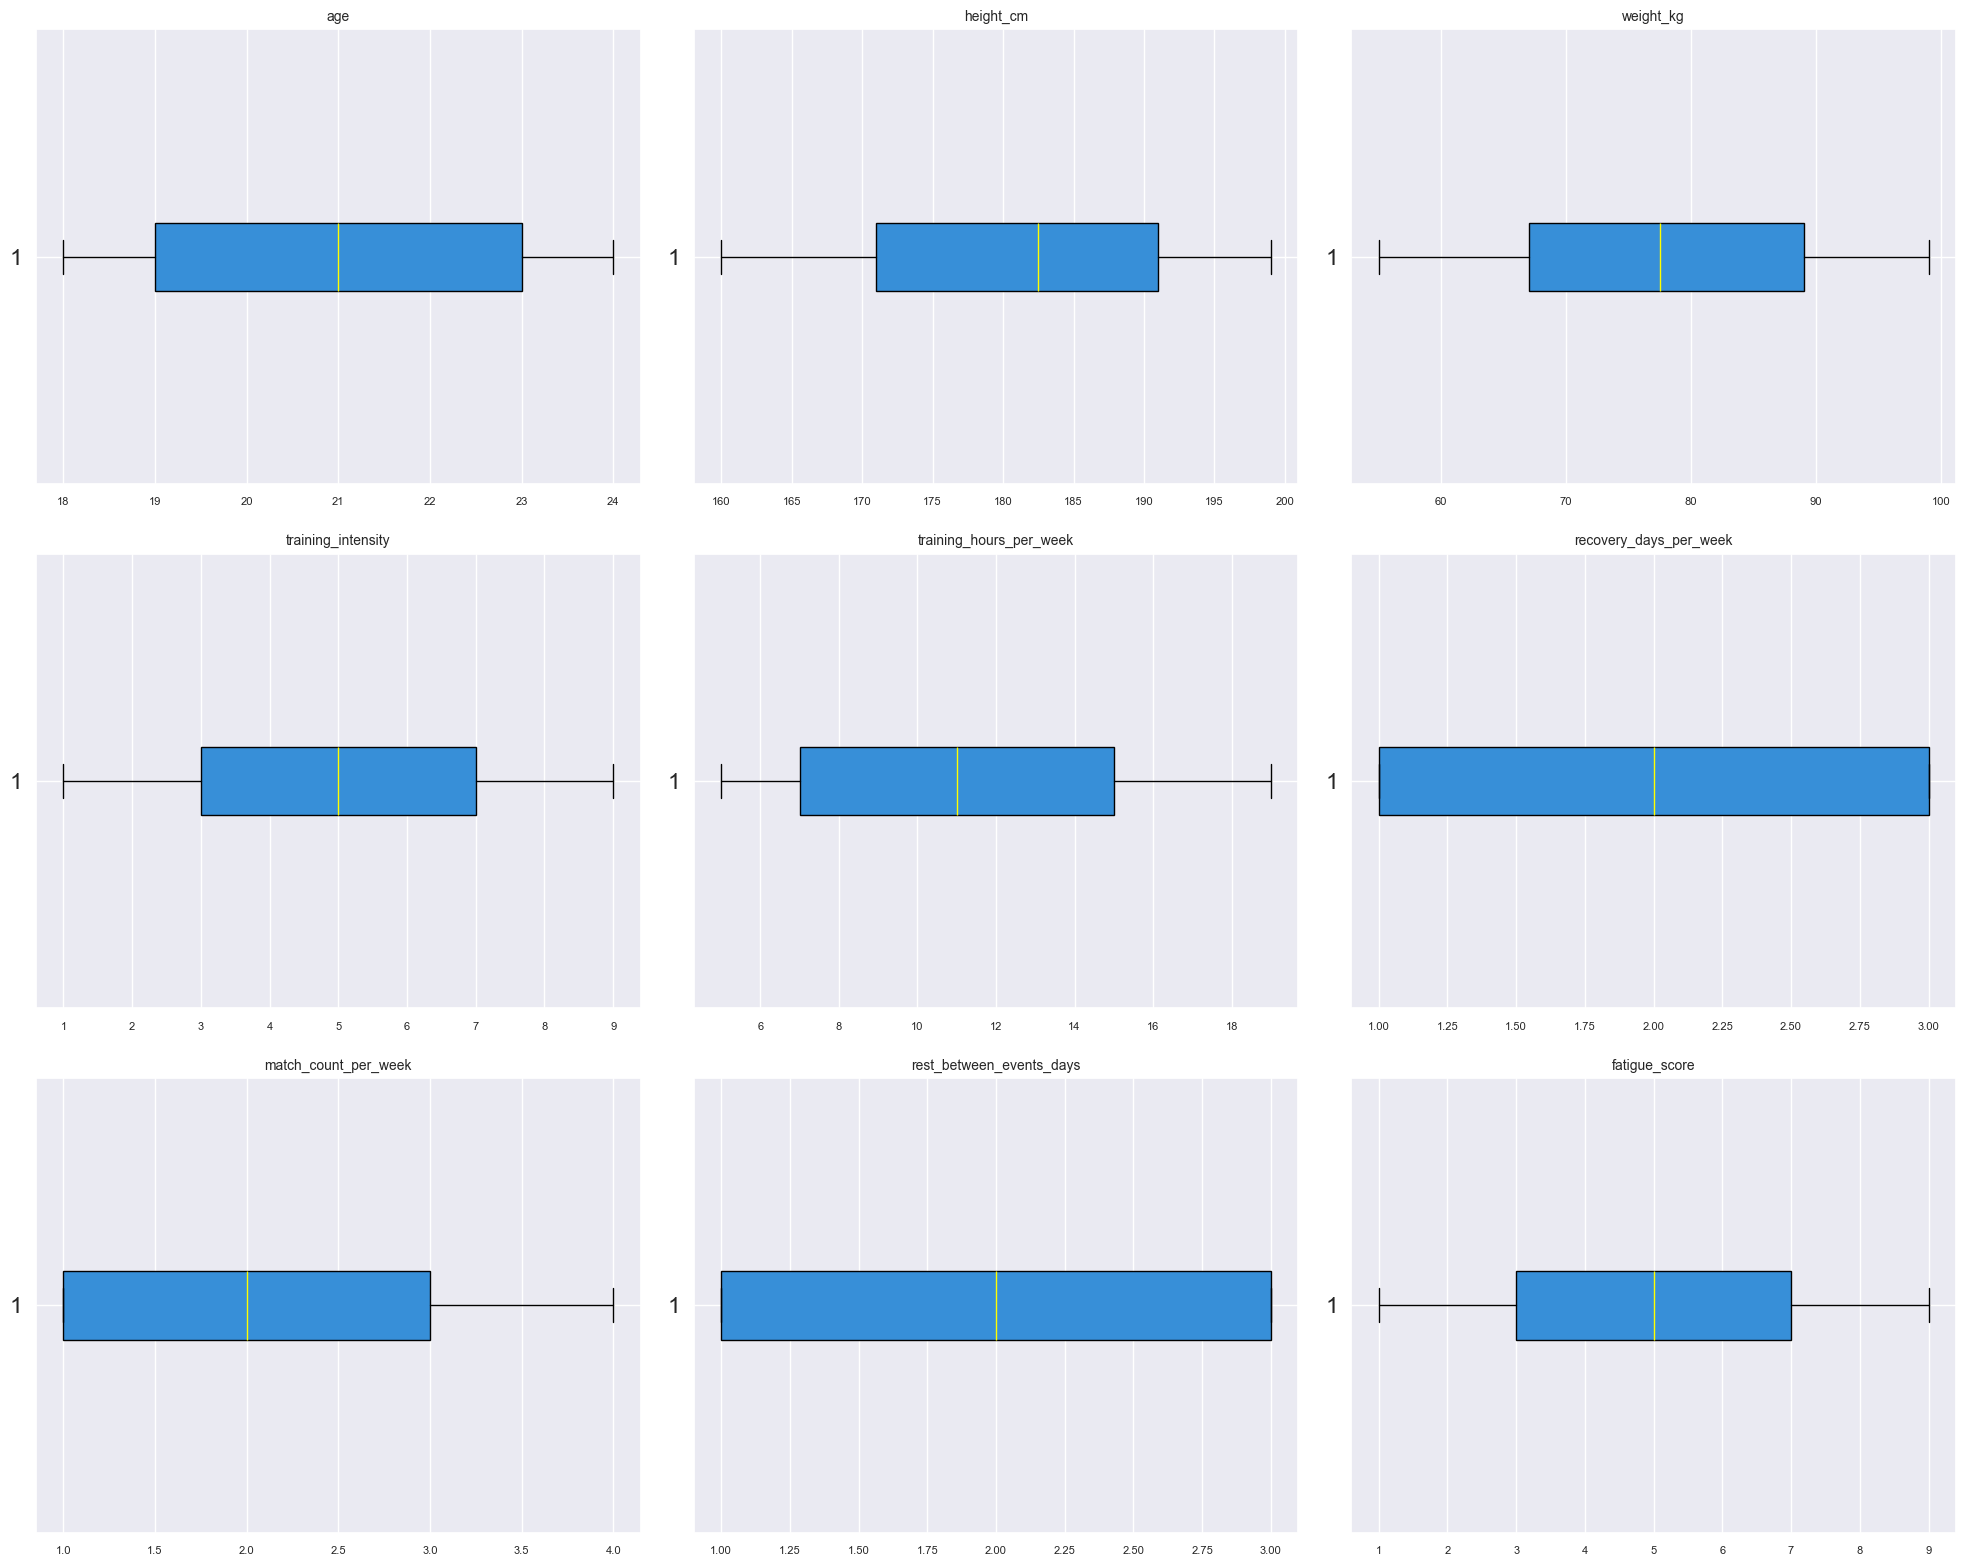

In [58]:
color = '#378fd8'

# grid size
nrows, ncols = 3, 3 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    

plt.tight_layout()
plt.show()